## Neste documento, adicionaremos a tag legal/ilegal nos dados
- Importação dos dados
- Divisão por grupo de tipo de licitação
- Criação do algorítmo de classificação
- Implementação nas bases divididas por modalidade de licitação

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%time
path = r'C:\licitacoes_08_a_12_2021'
filenames = glob.glob(path + "/*.csv")

li= []

for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0, decimal=',',sep=';',encoding='latin1')
    li.append(df)

df_lic_2021 = pd.concat(li, axis=0, ignore_index=True)

Wall time: 0 ns


In [3]:
pd.options.display.max_colwidth = 1000

In [4]:
df_lic_2021.head(1)

,Número Licitação,Código UG,Nome UG,Código Modalidade Compra,Modalidade Compra,Número Processo,Objeto,Situação Licitação,Código Órgão Superior,Nome Órgão Superior,Código Órgão,Nome Órgão,Município,Data Resultado Compra,Data Abertura,Valor Licitação
0,12019,154628,INST.FEDERAL FARROUPILHA CAMPUS JAGUARI,2,Tomada de Preços,26420000767201908,"Objeto: Contratação de pessoa jurídica especializada na prestação de serviços de engenharia para elaboração e aprovação do plano de prevenção e proteção contra incêndio, com a emissão do certificado de aprovação pelo corpo de bombeiros de Santiago, e respectivo projeto executivo completo, das edificações existentes do Campus Jaguari, conforme condições, quantidades e exigências estabelecidas no edital e seus anexos",Evento de Resultado de Julgame,26000,Ministério da Educação,26420,Instituto Federal Farroupilha,JAGUARI,28/01/2021,NaN,14784.85


In [5]:
df_lic_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60501 entries, 0 to 60500
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Número Licitação          60501 non-null  int64  
 1   Código UG                 60501 non-null  int64  
 2   Nome UG                   60501 non-null  object 
 3   Código Modalidade Compra  60501 non-null  int64  
 4   Modalidade Compra         60501 non-null  object 
 5   Número Processo           60501 non-null  object 
 6   Objeto                    60501 non-null  object 
 7   Situação Licitação        60501 non-null  object 
 8   Código Órgão Superior     60501 non-null  int64  
 9   Nome Órgão Superior       60501 non-null  object 
 10  Código Órgão              60501 non-null  int64  
 11  Nome Órgão                60501 non-null  object 
 12  Município                 60501 non-null  object 
 13  Data Resultado Compra     60501 non-null  object 
 14  Data A

In [6]:
df_lic_2021.shape

(60501, 16)

In [7]:
df_lic_2021.rename(columns={"Valor Licitação": "Total"},inplace=True)

In [8]:
df_lic_2021['Modalidade Compra'].value_counts()

Dispensa de Licitação               32774
Pregão - Registro de Preço          11654
Pregão                               8695
Inexigibilidade de Licitação         7200
Tomada de Preços                      124
Concorrência                           39
Convite                                 7
Concurso                                4
Concorrência - Registro de Preço        4
Name: Modalidade Compra, dtype: int64

## É Obra ?

In [9]:
df_lic_2021['Obras'] = df_lic_2021['Objeto'].str.contains("OBRAS|OBRA|obras|obra|ENGENHARIA|engenharia|CONSTRU-CAO|constru-cao", na=False)

In [10]:
df_lic_2021['Obras'].value_counts()

False    58493
True      2008
Name: Obras, dtype: int64

In [11]:
df_lic_2021['Tipo'] = 1

In [12]:
df_lic_2021.loc[df_lic_2021['Obras'] == True, 'Tipo'] = 'Obras'
df_lic_2021.loc[df_lic_2021['Obras'] == False, 'Tipo'] = 'Compras/Servicos'

In [13]:
df_lic_2021['Tipo'].value_counts()

Compras/Servicos    58493
Obras                2008
Name: Tipo, dtype: int64

In [14]:
#Excluindo o atributo Obras que não será utilizado nas análises posteriores.
df_lic_2021.drop(columns=['Obras'], axis=1, inplace=True)

In [15]:
df_lic_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60501 entries, 0 to 60500
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Número Licitação          60501 non-null  int64  
 1   Código UG                 60501 non-null  int64  
 2   Nome UG                   60501 non-null  object 
 3   Código Modalidade Compra  60501 non-null  int64  
 4   Modalidade Compra         60501 non-null  object 
 5   Número Processo           60501 non-null  object 
 6   Objeto                    60501 non-null  object 
 7   Situação Licitação        60501 non-null  object 
 8   Código Órgão Superior     60501 non-null  int64  
 9   Nome Órgão Superior       60501 non-null  object 
 10  Código Órgão              60501 non-null  int64  
 11  Nome Órgão                60501 non-null  object 
 12  Município                 60501 non-null  object 
 13  Data Resultado Compra     60501 non-null  object 
 14  Data A

# Separando as Licitações por Modalidade de Compra e aplicando as regras de acordo com os valores a partir do Decreto n. 9.412, de 18 de Junho de 2021.

## Registro de Preço/ Concorrência/Concorrência - Registro de Preço

In [16]:
df_lic_2021_RP = df_lic_2021[(df_lic_2021['Modalidade Compra']  == 'Pregão - Registro de Preço') | (df_lic_2021['Modalidade Compra'] == 'Concorrência - Registro de Preço') | (df_lic_2021['Modalidade Compra'] == 'Concorrência')]

In [17]:
df_lic_2021_RP['Modalidade Compra'].value_counts()

Pregão - Registro de Preço          11654
Concorrência                           39
Concorrência - Registro de Preço        4
Name: Modalidade Compra, dtype: int64

In [18]:
df_lic_2021_RP['Tipo'].value_counts()

Compras/Servicos    11381
Obras                 316
Name: Tipo, dtype: int64

In [19]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_RP_2021 = df_lic_2021_RP[df_lic_2021_RP['Tipo'] == 'Obras']
lic_compras_RP_2021 = df_lic_2021_RP[df_lic_2021_RP['Tipo'] != 'Obras']

## Tag'ando como legal ou ilegal de acordo  com Decreto nº 9.412, de 18 de Junho de 2021

#### 0: ilegal
#### 1: legal

In [20]:
lic_obras_RP_2021['Tag'] = 0
lic_compras_RP_2021['Tag'] = 0

C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/1138545667.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_RP_2021['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/1138545667.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_RP_2021['Tag'] = 0


In [21]:
#regra de limite de valor
#Considerando REGISTRO DE PREÇO como CONCORRENCIA e CONCORRENCIA - REGISTRO DE PREÇO
lic_obras_RP_2021.loc[lic_obras_RP_2021['Total'] > 3300000, 'Tag'] = 1
lic_compras_RP_2021.loc[lic_compras_RP_2021['Total'] > 1430000, 'Tag'] = 1

C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [22]:
lic_obras_RP_2021['Tag'].value_counts()

0    293
1     23
Name: Tag, dtype: int64

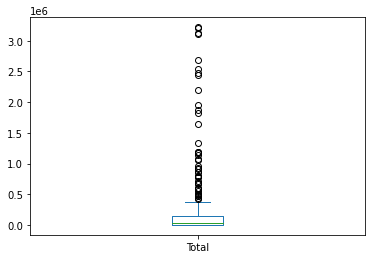

In [23]:
# Análise visual das licitações Ilegais para esta modalidade
lic_obras_RP_2021[lic_obras_RP_2021['Tag'] == 0]['Total'].plot.box()
plt.show()

In [24]:
lic_obras_RP_2021[lic_obras_RP_2021['Tag'] == 0]['Total'].describe()

count    2.930000e+02
mean     2.433340e+05
std      5.568933e+05
min      0.000000e+00
25%      2.196000e+03
50%      3.532800e+04
75%      1.505868e+05
max      3.221162e+06
Name: Total, dtype: float64

<AxesSubplot:>

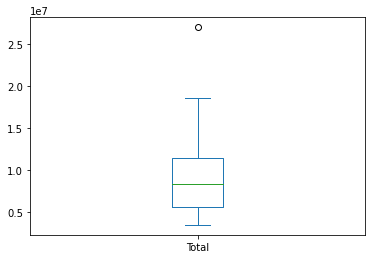

In [25]:
lic_obras_RP_2021[lic_obras_RP_2021['Tag'] == 1]['Total'].plot.box()

In [26]:
lic_compras_RP_2021['Tag'].value_counts()

0    11089
1      292
Name: Tag, dtype: int64

<AxesSubplot:>

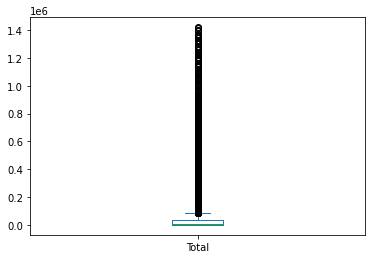

In [27]:
# Visualizando as licitações do tipo Registro de Preço que foram Ilegais
lic_compras_RP_2021[lic_compras_RP_2021['Tag'] == 0]['Total'].plot.box()

In [28]:
lic_compras_RP_2021[lic_compras_RP_2021['Tag'] == 0]['Total'].describe()

count    1.108900e+04
mean     5.806539e+04
std      1.608484e+05
min      0.000000e+00
25%      0.000000e+00
50%      4.375000e+03
75%      3.392500e+04
max      1.420000e+06
Name: Total, dtype: float64

<AxesSubplot:>

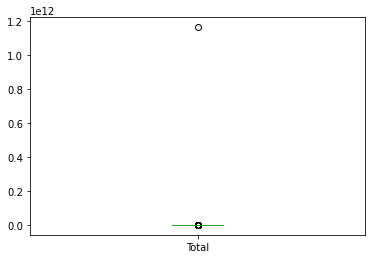

In [29]:
# Visualizando as licitações do tipo Registro de Preço que foram Legais
lic_compras_RP_2021[lic_compras_RP_2021['Tag'] == 1]['Total'].plot.box()

In [30]:
lic_compras_RP_2021[lic_compras_RP_2021['Tag'] == 1]['Total'].describe()

count    2.920000e+02
mean     3.992714e+09
std      6.800897e+10
min      1.431500e+06
25%      2.098638e+06
50%      3.326234e+06
75%      7.981748e+06
max      1.162150e+12
Name: Total, dtype: float64

## Dispensa de Licitação

In [31]:
df_lic_2021_Dispensa = df_lic_2021[df_lic_2021['Modalidade Compra'] == 'Dispensa de Licitação']

In [32]:
df_lic_2021_Dispensa['Modalidade Compra'].value_counts()

Dispensa de Licitação    32774
Name: Modalidade Compra, dtype: int64

In [33]:
df_lic_2021_Dispensa['Tipo'].value_counts()

Compras/Servicos    32110
Obras                 664
Name: Tipo, dtype: int64

In [34]:
lic_obras_Dispensa_2021 = df_lic_2021_Dispensa[df_lic_2021_Dispensa['Tipo'] == 'Obras']
lic_compras_Dispensa_2021 = df_lic_2021_Dispensa[df_lic_2021_Dispensa['Tipo'] != 'Obras']

In [35]:
lic_obras_Dispensa_2021['Tipo'].value_counts()

Obras    664
Name: Tipo, dtype: int64

In [36]:
lic_compras_Dispensa_2021['Tipo'].value_counts()

Compras/Servicos    32110
Name: Tipo, dtype: int64

## Tag'ando como legal ou ilegal de acordo com Decreto nº 9.412, de 18 de Junho de 2021

#### 0: ilegal
#### 1: legal

In [37]:
lic_obras_Dispensa_2021['Tag'] = 0
lic_compras_Dispensa_2021['Tag'] = 0

C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/361519389.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_Dispensa_2021['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/361519389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_Dispensa_2021['Tag'] = 0


In [38]:
#regra de limite de valor
lic_obras_Dispensa_2021.loc[lic_obras_Dispensa_2021['Total'] <= 33000 , 'Tag'] = 1
lic_compras_Dispensa_2021.loc[lic_compras_Dispensa_2021['Total'] <= 17600, 'Tag'] = 1

C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [39]:
lic_obras_Dispensa_2021['Tag'].value_counts()

1    527
0    137
Name: Tag, dtype: int64

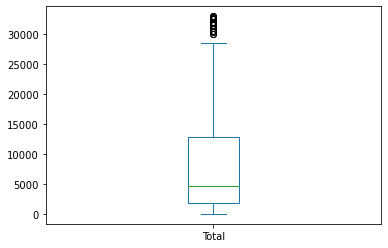

In [40]:
lic_obras_Dispensa_2021[lic_obras_Dispensa_2021['Tag'] == 1]['Total'].plot.box()
plt.show()

In [41]:
lic_obras_Dispensa_2021[lic_obras_Dispensa_2021['Tag'] == 1]['Total'].describe()

count      527.000000
mean      8185.570645
std       8411.252362
min         65.960000
25%       1824.140000
50%       4690.000000
75%      12850.000000
max      32980.000000
Name: Total, dtype: float64

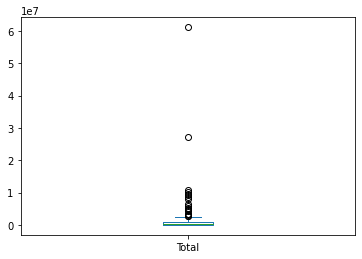

In [42]:
lic_obras_Dispensa_2021[lic_obras_Dispensa_2021['Tag'] == 0]['Total'].plot.box()
plt.show()

In [43]:
lic_obras_Dispensa_2021[lic_obras_Dispensa_2021['Tag'] == 0]['Total'].describe()

count    1.370000e+02
mean     1.799213e+06
std      5.976249e+06
min      3.546900e+04
25%      1.318560e+05
50%      3.039840e+05
75%      1.046310e+06
max      6.109862e+07
Name: Total, dtype: float64

In [44]:
lic_compras_Dispensa_2021['Tag'].value_counts()

1    29144
0     2966
Name: Tag, dtype: int64

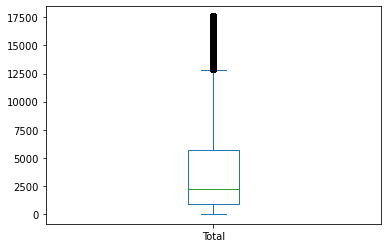

In [45]:
lic_compras_Dispensa_2021[lic_compras_Dispensa_2021['Tag'] == 1]['Total'].plot.box()
plt.show()

In [46]:
lic_compras_Dispensa_2021[lic_compras_Dispensa_2021['Tag'] == 1]['Total'].describe()

count    29144.000000
mean      4066.511690
std       4458.889281
min          0.000000
25%        878.000000
50%       2250.000000
75%       5670.000000
max      17600.000000
Name: Total, dtype: float64

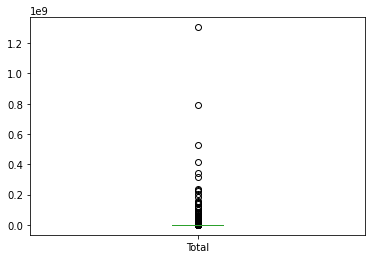

In [47]:
lic_compras_Dispensa_2021[lic_compras_Dispensa_2021['Tag'] == 0]['Total'].plot.box()
plt.show()

In [48]:
lic_compras_Dispensa_2021[lic_compras_Dispensa_2021['Tag'] == 0]['Total'].describe()

count    2.966000e+03
mean     3.269302e+06
std      3.433755e+07
min      1.761047e+04
25%      3.252295e+04
50%      8.802750e+04
75%      3.996757e+05
max      1.305345e+09
Name: Total, dtype: float64

## Tomada de Preço

In [49]:
df_lic_2021_tomada_de_preco = df_lic_2021[df_lic_2021['Modalidade Compra'] == 'Tomada de Preços']

In [50]:
df_lic_2021_tomada_de_preco['Modalidade Compra'].value_counts()

Tomada de Preços    124
Name: Modalidade Compra, dtype: int64

In [51]:
df_lic_2021_tomada_de_preco['Tipo'].value_counts()

Compras/Servicos    83
Obras               41
Name: Tipo, dtype: int64

In [52]:
lic_obras_tomada_de_preco_2021 = df_lic_2021_tomada_de_preco[df_lic_2021_tomada_de_preco['Tipo'] == 'Obras']
lic_compras_tomada_de_preco_2021 = df_lic_2021_tomada_de_preco[df_lic_2021_tomada_de_preco['Tipo'] != 'Obras']

In [53]:
lic_obras_tomada_de_preco_2021['Tipo'].value_counts()

Obras    41
Name: Tipo, dtype: int64

In [54]:
lic_compras_tomada_de_preco_2021['Tipo'].value_counts()

Compras/Servicos    83
Name: Tipo, dtype: int64

In [55]:
## Tag'ando como legal ou ilegal de acordo com Decreto nº 9.412, de 18 de Junho de 2021

#### 0: ilegal
#### 1: legal

lic_obras_tomada_de_preco_2021['Tag'] = 0
lic_compras_tomada_de_preco_2021['Tag'] = 0

#regra de limite de valor
lic_obras_tomada_de_preco_2021.loc[(lic_obras_tomada_de_preco_2021['Total'] >  330000) & (lic_obras_tomada_de_preco_2021['Total'] <=   3300000) , 'Tag'] = 1
lic_compras_tomada_de_preco_2021.loc[(lic_compras_tomada_de_preco_2021['Total'] >  176000) & (lic_compras_tomada_de_preco_2021['Total'] <=  1400000), 'Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/1523434533.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_tomada_de_preco_2021['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/1523434533.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_tomada_de_preco_2021['Tag'] = 0
C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [56]:
lic_obras_tomada_de_preco_2021['Tag'].value_counts()

0    21
1    20
Name: Tag, dtype: int64

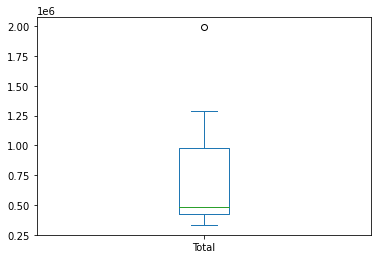

In [57]:
lic_obras_tomada_de_preco_2021[lic_obras_tomada_de_preco_2021['Tag'] == 1]['Total'].plot.box()
plt.show()

In [58]:
lic_obras_tomada_de_preco_2021[lic_obras_tomada_de_preco_2021['Tag'] == 1]['Total'].describe()

count    2.000000e+01
mean     7.185772e+05
std      4.269313e+05
min      3.327172e+05
25%      4.219672e+05
50%      4.828682e+05
75%      9.792962e+05
max      1.990524e+06
Name: Total, dtype: float64

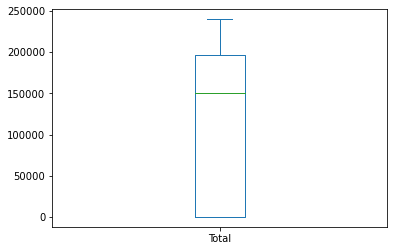

In [59]:
lic_obras_tomada_de_preco_2021[lic_obras_tomada_de_preco_2021['Tag'] == 0]['Total'].plot.box()
plt.show()

In [60]:
lic_compras_tomada_de_preco_2021['Tag'].value_counts()

1    52
0    31
Name: Tag, dtype: int64

In [61]:
# Licitaçoes Legais
lic_compras_tomada_de_preco_2021[lic_compras_tomada_de_preco_2021['Tag'] == 1]['Total'].describe()

count    5.200000e+01
mean     5.474011e+05
std      3.499048e+05
min      1.769928e+05
25%      2.795192e+05
50%      4.012408e+05
75%      8.320564e+05
max      1.303755e+06
Name: Total, dtype: float64

In [62]:
lic_compras_tomada_de_preco_2021[lic_compras_tomada_de_preco_2021['Tag'] == 1]['Total'].describe()

count    5.200000e+01
mean     5.474011e+05
std      3.499048e+05
min      1.769928e+05
25%      2.795192e+05
50%      4.012408e+05
75%      8.320564e+05
max      1.303755e+06
Name: Total, dtype: float64

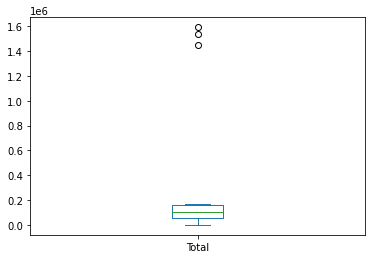

In [63]:
# Licitações Ilegais
lic_compras_tomada_de_preco_2021[lic_compras_tomada_de_preco_2021['Tag'] == 0]['Total'].plot.box()
plt.show()

In [64]:
lic_compras_tomada_de_preco_2021[lic_compras_tomada_de_preco_2021['Tag'] == 0]['Total'].describe()

count    3.100000e+01
mean     2.297660e+05
std      4.352609e+05
min      0.000000e+00
25%      5.803279e+04
50%      1.027142e+05
75%      1.567267e+05
max      1.591122e+06
Name: Total, dtype: float64

## Convite

In [65]:
df_lic_2021_convite = df_lic_2021[df_lic_2021['Modalidade Compra'] == 'Convite']

In [66]:
df_lic_2021_convite['Modalidade Compra'].value_counts()

Convite    7
Name: Modalidade Compra, dtype: int64

In [67]:
df_lic_2021_convite['Tipo'].value_counts()

Compras/Servicos    5
Obras               2
Name: Tipo, dtype: int64

In [68]:
lic_compras_convite_2021 = df_lic_2021_convite[df_lic_2021_convite['Tipo'] != 'Obras']
lic_obras_convite_2021 = df_lic_2021_convite[df_lic_2021_convite['Tipo'] == 'Obras']

In [69]:
lic_compras_convite_2021['Tipo'].value_counts()

Compras/Servicos    5
Name: Tipo, dtype: int64

In [70]:
lic_obras_convite_2021['Tipo'].value_counts()

Obras    2
Name: Tipo, dtype: int64

In [71]:
## Tag'ando como legal ou ilegal de acordo com Decreto nº 9.412, de 18 de Junho de 2021

#### 0: ilegal
#### 1: legal

lic_compras_convite_2021['Tag'] = 0
lic_obras_convite_2021['Tag'] = 0

#regra de limite de valor
lic_compras_convite_2021.loc[(lic_compras_convite_2021['Total'] >  17600) & (lic_compras_convite_2021['Total'] <=   176000) , 'Tag'] = 1
lic_obras_convite_2021.loc[(lic_obras_convite_2021['Total'] >  33000) & (lic_obras_convite_2021['Total'] <=   330000), 'Tag'] = 1


C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/2312457054.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_convite_2021['Tag'] = 0
C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/2312457054.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_convite_2021['Tag'] = 0
C:\Users\lrr\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [72]:
lic_compras_convite_2021['Tag'].value_counts()

1    4
0    1
Name: Tag, dtype: int64

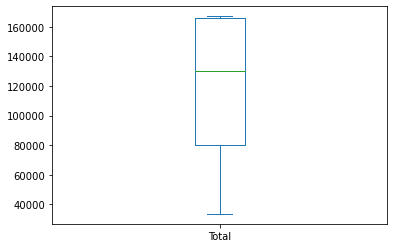

In [73]:
lic_compras_convite_2021[lic_compras_convite_2021['Tag'] == 1]['Total'].plot.box()
plt.show()

In [74]:
lic_compras_convite_2021[lic_compras_convite_2021['Tag'] == 1]['Total'].describe()

count         4.000000
mean     115417.777500
std       63899.355168
min       33580.000000
25%       80145.385000
50%      130468.420000
75%      165740.812500
max      167154.270000
Name: Total, dtype: float64

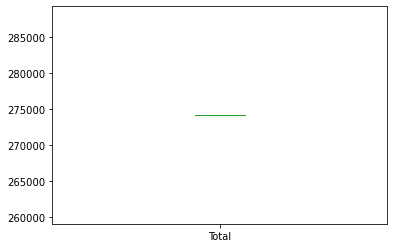

In [75]:
lic_compras_convite_2021[lic_compras_convite_2021['Tag'] == 0]['Total'].plot.box()
plt.show()

In [76]:
lic_compras_convite_2021[lic_compras_convite_2021['Tag'] == 0]['Total'].describe()

count         1.00
mean     274132.22
std            NaN
min      274132.22
25%      274132.22
50%      274132.22
75%      274132.22
max      274132.22
Name: Total, dtype: float64

In [77]:
lic_obras_convite_2021['Tag'].value_counts()

1    2
Name: Tag, dtype: int64

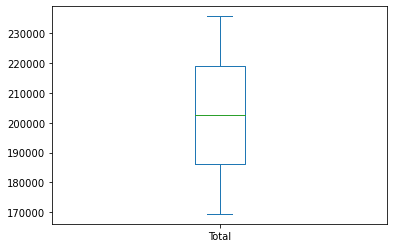

In [78]:
lic_obras_convite_2021[lic_obras_convite_2021['Tag'] == 1]['Total'].plot.box()
plt.show()

In [79]:
lic_obras_convite_2021[lic_obras_convite_2021['Tag'] == 1]['Total'].describe()

count         2.000000
mean     202582.835000
std       46899.953278
min      169419.560000
25%      186001.197500
50%      202582.835000
75%      219164.472500
max      235746.110000
Name: Total, dtype: float64

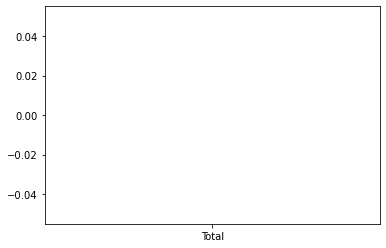

In [80]:
lic_obras_convite_2021[lic_obras_convite_2021['Tag'] == 0]['Total'].plot.box()
plt.show()

In [81]:
lic_obras_convite_2021[lic_obras_convite_2021['Tag'] == 0]['Total'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Total, dtype: float64

### As modalidades abaixo não possuem uma regra bem definida para os valores de Licitação. Dessa forma, será atribuido a tag legal como padrão.

## Pregão

In [82]:
df_lic_2021_Pregao = df_lic_2021[df_lic_2021['Modalidade Compra'] == 'Pregão']

In [83]:
df_lic_2021_Pregao['Modalidade Compra'].value_counts()

Pregão    8695
Name: Modalidade Compra, dtype: int64

In [84]:
df_lic_2021_Pregao['Tipo'].value_counts()

Compras/Servicos    7813
Obras                882
Name: Tipo, dtype: int64

In [85]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_Pregao_2021 = df_lic_2021_Pregao[df_lic_2021_Pregao['Tipo'] == 'Obras']
lic_compras_Pregao_2021 = df_lic_2021_Pregao[df_lic_2021_Pregao['Tipo'] != 'Obras']

In [86]:
lic_obras_Pregao_2021['Tipo'].value_counts()

Obras    882
Name: Tipo, dtype: int64

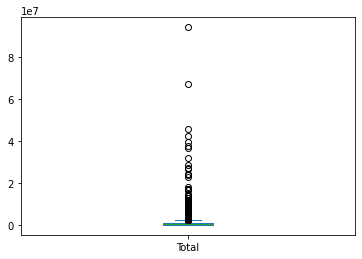

In [87]:
lic_obras_Pregao_2021['Total'].plot.box()
plt.show()

In [88]:
lic_obras_Pregao_2021['Total'].describe()

count    8.820000e+02
mean     1.762575e+06
std      5.904885e+06
min      0.000000e+00
25%      4.809994e+04
50%      2.459634e+05
75%      9.189452e+05
max      9.437908e+07
Name: Total, dtype: float64

In [89]:
lic_compras_Pregao_2021['Tipo'].value_counts()

Compras/Servicos    7813
Name: Tipo, dtype: int64

<AxesSubplot:>

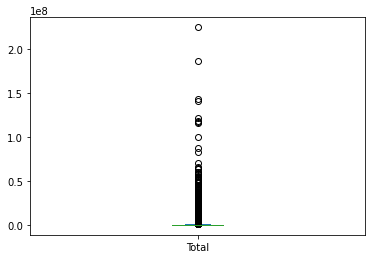

In [90]:
lic_compras_Pregao_2021['Total'].plot.box()

In [91]:
lic_compras_Pregao_2021['Total'].describe()

count    7.813000e+03
mean     1.350010e+06
std      6.942012e+06
min      0.000000e+00
25%      1.103000e+04
50%      7.292575e+04
75%      3.717270e+05
max      2.243618e+08
Name: Total, dtype: float64

In [92]:
## Tag'ando como legal já que não existe uma regra bem definida para a modalidade Pregão

#### 0: ilegal
#### 1: legal
lic_obras_Pregao_2021['Tag'] = 1
lic_compras_Pregao_2021['Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/2157594586.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_Pregao_2021['Tag'] = 1
C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/2157594586.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_Pregao_2021['Tag'] = 1


In [93]:
lic_obras_Pregao_2021['Tag'].value_counts()

1    882
Name: Tag, dtype: int64

In [94]:
lic_compras_Pregao_2021['Tag'].value_counts()

1    7813
Name: Tag, dtype: int64

## Inexigibilidade de Licitação 

In [95]:
df_lic_2021_Inex_2021 = df_lic_2021[df_lic_2021['Modalidade Compra'] == 'Inexigibilidade de Licitação']

In [96]:
df_lic_2021_Inex_2021['Modalidade Compra'].value_counts()

Inexigibilidade de Licitação    7200
Name: Modalidade Compra, dtype: int64

In [97]:
df_lic_2021_Inex_2021['Tipo'].value_counts()

Compras/Servicos    7098
Obras                102
Name: Tipo, dtype: int64

In [98]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_Inex_2021 = df_lic_2021_Inex_2021[df_lic_2021_Inex_2021['Tipo'] == 'Obras']
lic_compras_Inex_2021 = df_lic_2021_Inex_2021[df_lic_2021_Inex_2021['Tipo'] != 'Obras']

In [99]:
lic_obras_Inex_2021['Tipo'].value_counts()

Obras    102
Name: Tipo, dtype: int64

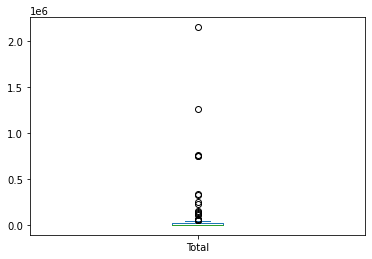

In [100]:
lic_obras_Inex_2021['Total'].plot.box()
plt.show()

In [101]:
lic_obras_Inex_2021['Total'].describe()

count    1.020000e+02
mean     8.055013e+04
std      2.761753e+05
min      1.000000e-02
25%      9.992500e+02
50%      4.230570e+03
75%      1.921847e+04
max      2.152080e+06
Name: Total, dtype: float64

In [102]:
lic_compras_Inex_2021['Tipo'].value_counts()

Compras/Servicos    7098
Name: Tipo, dtype: int64

<AxesSubplot:>

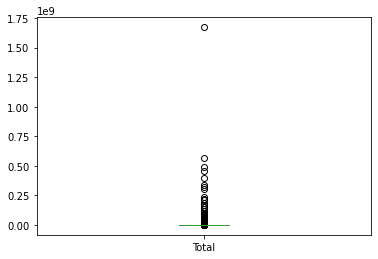

In [103]:
lic_compras_Inex_2021['Total'].plot.box()

In [104]:
lic_compras_Inex_2021['Total'].describe()

count    7.098000e+03
mean     1.550605e+06
std      2.515202e+07
min      1.000000e-02
25%      2.305300e+03
50%      1.078200e+04
75%      8.563152e+04
max      1.672397e+09
Name: Total, dtype: float64

In [105]:
## Tag'ando como legal já que não existe uma regra bem definida para esta modalidade

#### 0: ilegal
#### 1: legal
lic_obras_Inex_2021['Tag'] = 1
lic_compras_Inex_2021['Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/2614257969.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_Inex_2021['Tag'] = 1
C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/2614257969.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_Inex_2021['Tag'] = 1


In [106]:
lic_obras_Inex_2021['Tag'].value_counts()

1    102
Name: Tag, dtype: int64

In [107]:
lic_compras_Inex_2021['Tag'].value_counts()

1    7098
Name: Tag, dtype: int64

## Concurso

In [108]:
df_lic_2021_concurso = df_lic_2021[df_lic_2021['Modalidade Compra'] == 'Concurso']

In [109]:
df_lic_2021_concurso['Modalidade Compra'].value_counts()

Concurso    4
Name: Modalidade Compra, dtype: int64

In [110]:
df_lic_2021_concurso['Tipo'].value_counts()

Compras/Servicos    3
Obras               1
Name: Tipo, dtype: int64

In [111]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_concurso_2021 = df_lic_2021_concurso[df_lic_2021_concurso['Tipo'] == 'Obras']
lic_compras_concurso_2021 = df_lic_2021_concurso[df_lic_2021_concurso['Tipo'] != 'Obras']

In [112]:
lic_obras_concurso_2021['Tipo'].value_counts()

Obras    1
Name: Tipo, dtype: int64

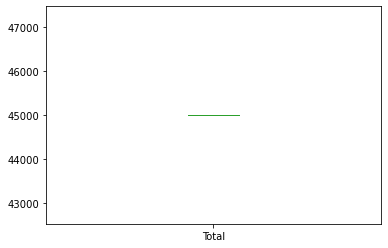

In [113]:
lic_obras_concurso_2021['Total'].plot.box()
plt.show()

<AxesSubplot:>

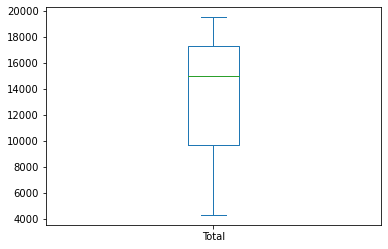

In [114]:
lic_compras_concurso_2021['Total'].plot.box()

In [115]:
lic_compras_concurso_2021['Total'].describe()

count        3.000000
mean     12930.180000
std       7803.924814
min       4300.000000
25%       9650.000000
50%      15000.000000
75%      17245.270000
max      19490.540000
Name: Total, dtype: float64

In [116]:
## Tag'ando como legal já que não existe uma regra bem definida para esta modalidade

#### 0: ilegal
#### 1: legal
lic_obras_concurso_2021['Tag'] = 1
lic_compras_concurso_2021['Tag'] = 1

C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/2737587005.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_obras_concurso_2021['Tag'] = 1
C:\Users\lrr\AppData\Local\Temp/ipykernel_22940/2737587005.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lic_compras_concurso_2021['Tag'] = 1


In [117]:
lic_obras_concurso_2021['Tag'].value_counts()

1    1
Name: Tag, dtype: int64

In [118]:
lic_compras_concurso_2021['Tag'].value_counts()

1    3
Name: Tag, dtype: int64

### Concorrência Internacional

In [119]:
df_lic_2021_concorrencia_internacional = df_lic_2021[df_lic_2021['Modalidade Compra'] == 'Concorrência Internacional']

In [120]:
df_lic_2021_concorrencia_internacional['Modalidade Compra'].value_counts()

Series([], Name: Modalidade Compra, dtype: int64)

In [121]:
# Separando a modalidade em Obras e Compras/Serviços
lic_obras_concorrencia_internacional_2021 = df_lic_2021_concorrencia_internacional[df_lic_2021_concorrencia_internacional['Tipo'] == 'Obras']
lic_compras_concorrencia_internacional_2021 = df_lic_2021_concorrencia_internacional[df_lic_2021_concorrencia_internacional['Tipo'] != 'Obras']

In [122]:
lic_obras_concorrencia_internacional_2021['Tipo'].value_counts()

Series([], Name: Tipo, dtype: int64)

In [123]:
lic_compras_concorrencia_internacional_2021['Tipo'].value_counts()

Series([], Name: Tipo, dtype: int64)

<AxesSubplot:>

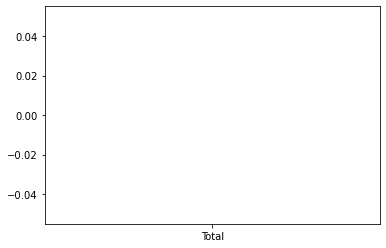

In [124]:
lic_compras_concorrencia_internacional_2021['Total'].plot.box()

In [125]:
lic_compras_concorrencia_internacional_2021['Total'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: Total, dtype: float64

In [126]:
## Tag'ando como legal já que não existe uma regra bem definida para esta modalidade

#### 0: ilegal
#### 1: legal
lic_obras_concorrencia_internacional_2021['Tag'] = 1
lic_compras_concorrencia_internacional_2021['Tag'] = 1

In [127]:
lic_obras_concorrencia_internacional_2021['Tag'].value_counts()

Series([], Name: Tag, dtype: int64)

In [128]:
lic_compras_concorrencia_internacional_2021['Tag'].value_counts()

Series([], Name: Tag, dtype: int64)

### Salvando todas as analises em uma única base de dados.

In [129]:
lic_2021_com_tag = pd.concat([lic_obras_RP_2021, lic_compras_RP_2021, lic_obras_Dispensa_2021, lic_compras_Dispensa_2021, lic_obras_tomada_de_preco_2021, lic_compras_tomada_de_preco_2021, lic_compras_convite_2021, lic_obras_convite_2021, lic_obras_Pregao_2021, lic_compras_Pregao_2021, lic_obras_Inex_2021, lic_compras_Inex_2021, lic_obras_concurso_2021, lic_compras_concurso_2021, lic_obras_concorrencia_internacional_2021, lic_compras_concorrencia_internacional_2021])

In [130]:
lic_2021_com_tag.to_csv('lic_2021_com_tag.csv')

In [131]:
lic_2021_com_tag['Tag'].value_counts()

1    45963
0    14538
Name: Tag, dtype: int64

In [132]:
lic_2021_com_tag.groupby(['Modalidade Compra','Tag', 'Tipo']).describe()

Número Licitação  \
                                                                 count   
Modalidade Compra                Tag Tipo                                
Concorrência                     0   Compras/Servicos             10.0   
                                     Obras                         8.0   
                                 1   Compras/Servicos             15.0   
                                     Obras                         6.0   
Concorrência - Registro de Preço 0   Compras/Servicos              3.0   
                                     Obras                         1.0   
Concurso                         1   Compras/Servicos              3.0   
                                     Obras                         1.0   
Convite                          0   Compras/Servicos              1.0   
                                 1   Compras/Servicos              4.0   
                                     Obras                         2.0   
Dispensa de Licitação            0   Compras/Servicos           2966.0   
                                     Obras                       137.0   
                                 1   Compras/Servicos          29144.0   
                                     Obras                       527.0   
Inexigibilidade de Licitação     1   Compras/Servicos           7098.0   
                                     Obras                       102.0   
Pregão                           1   Compras/Servicos           7813.0   
                                     Obras                       882.0   
Pregão - Registro de Preço       0   Compras/Servicos          11076.0   
                                     Obras                       284.0   
                                 1   Compras/Servicos            277.0   
                                     Obras                        17.0   
Tomada de Preços                 0   Compras/Servicos             31.0   
                                     Obras                        21.0   
                                 1   Compras/Servicos             52.0   
                                     Obras                        20.0   

                                                                     \
                                                               mean   
Modalidade Compra                Tag Tipo                             
Concorrência                     0   Compras/Servicos  4.180201e+05   
                                     Obras             2.826988e+04   
                                 1   Compras/Servicos  3.535333e+04   
                                     Obras             2.535350e+04   
Concorrência - Registro de Preço 0   Compras/Servicos  2.202000e+04   
                                     Obras             2.202000e+04   
Concurso                         1   Compras/Servicos  1.535400e+04   
                                     Obras             1.202000e+04   
Convite                          0   Compras/Servicos  1.202100e+04   
                                 1   Compras/Servicos  1.702025e+04   
                                     Obras             1.202050e+04   
Dispensa de Licitação            0   Compras/Servicos  1.067763e+07   
                                     Obras             1.167618e+07   
                                 1   Compras/Servicos  9.067363e+06   
                                     Obras             2.552401e+06   
Inexigibilidade de Licitação     1   Compras/Servicos  1.442265e+07   
                                     Obras             2.841139e+06   
Pregão                           1   Compras/Servicos  1.042952e+07   
                                     Obras             8.900989e+06   
Pregão - Registro de Preço       0   Compras/Servicos  9.728314e+06   
                                     Obras             1.315787e+07   
                                 1   Compras/Servicos  5.601118e+06   
                                     Obras             2.4